## **AIM:**
To address a research gap identified in the paper:
  ### “Enhancing Disease Prediction through Ensemble Learning Techniques” (IEEE).


## **GAP IDENTIFIED:** 
The paper discusses various ensemble methods such as bagging, boosting, and stacking for disease prediction. However, it lacks a detailed analysis of hyperparameter tuning and how it affects performance across these ensemble methods.

To fill this gap, ensemble models were implemented on the Breast Cancer Wisconsin dataset and hyperparameter tuning was conducted to analyze improvements in prediction accuracy.

#  **Breast Cancer Tumor Classification Using Ensemble Learning**
## **Objective:** 

Classify tumors as malignant or benign using ensemble methods and hyperparameter tuning, addressing the gap of analyzing hyperparameter impact in ensemble models.

### **Import Libraries**
Import libraries for data handling, modeling, tuning, and visualization.

In [1]:
# Core Python
import os
import time
import warnings
import numpy as np
import pandas as pd
from functools import partial
warnings.filterwarnings("ignore")

# Data Loading & EDA
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing & Feature Engineering
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    PowerTransformer
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Models – Base Ensemble Families
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Stacking & Meta-Learner
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Hyperparameter Optimization
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import (
    plot_param_importances,
    plot_optimization_history,
    plot_parallel_coordinate
)

# Model Evaluation & Metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay
)

# Calibration & Explainability
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import shap

# Statistical Tests
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

# Model Interpretability & Feature Importance
from sklearn.inspection import permutation_importance

# Visualization Styling
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("coolwarm")
sns.set(font_scale=1.1)

# Logging Utilities
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')


### Load Dataset

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [3]:
print(f"Dataset shape: {X.shape}")
print(f"Target Distribution:\n{pd.Series(y).value_counts(normalize=True)}")

Dataset shape: (569, 30)
Target Distribution:
1    0.627417
0    0.372583
Name: proportion, dtype: float64


### Step 1: Quick EDA & Cleanup

- **Dataset Loading:** Use `load_breast_cancer()` from scikit-learn and convert to a **pandas DataFrame** for easier inspection.  
- **Initial Exploration:**  
  - `.head()`, `.info()`, and `.describe()` to understand structure and detect missing values.  
- **Class Distribution:** Visualize using a **count plot** to check balance between malignant and benign tumors.  
- **Feature Relationships:**  
  - **Correlation heatmap** to identify highly correlated features that might be redundant.  
- **Feature Inspection:**  
  - **Histograms** and **boxplots** to observe distributions and detect potential outliers.


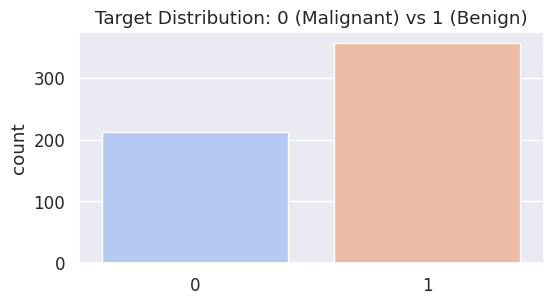

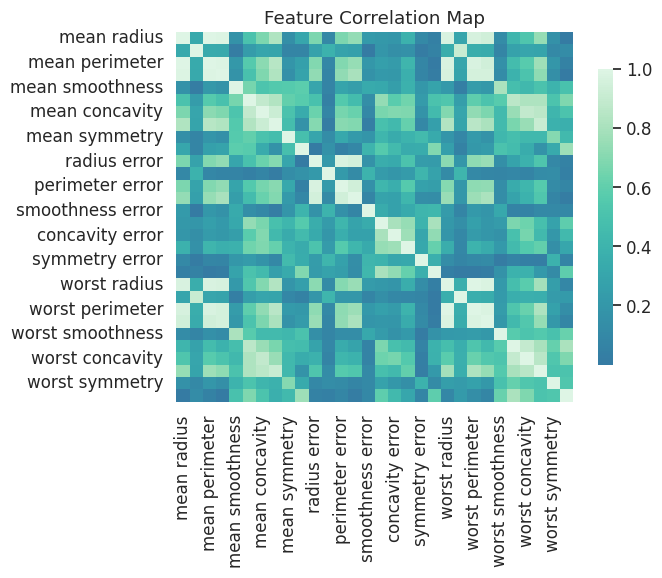

In [4]:
plt.figure(figsize=(6,3))
sns.countplot(x=y, palette="coolwarm")
plt.title("Target Distribution: 0 (Malignant) vs 1 (Benign)")
plt.show()

sns.heatmap(X.corr().abs(), cmap="mako", center=0, cbar_kws={"shrink":.8})
plt.title("Feature Correlation Map")
plt.show()

### Step 2: Feature Engineering & Preprocessing Choices

- **Remove Redundancy:** Drop highly correlated features (**correlation > 0.9**) to reduce multicollinearity.  
- **Scaling:** Use **StandardScaler()** to standardize features, ensuring models sensitive to scale (e.g., boosting) perform optimally.  
- **Optional Transformations:**  
  - **PowerTransformer** to stabilize variance and reduce skewness  
  - **PCA** for dimensionality reduction or visualizing clusters of malignant vs. benign tumors


In [5]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X_reduced = X.drop(columns=to_drop)

print(f"Reduced from {X.shape[1]} → {X_reduced.shape[1]} features after correlation filtering")


Reduced from 30 → 20 features after correlation filtering


### Step 3: Preprocessing Pipeline (CV-safe)

- **Pipeline Creation:** Encapsulate preprocessing and modeling steps together.  
- **Cross-Validation Safety:** Ensures operations like **scaling** or **feature selection** are applied **only on training folds**, preventing data leakage.  
- **Consistency:** Critical for **hyperparameter optimization** and **stacking**, maintaining a reproducible process across folds.


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

### Step 4: Train/Validation/Test Split (70/15/15)

- **Data Split:** Divide dataset into **training (70%)**, **validation (15%)**, and **test (15%)** sets.  
- **Stratification:** Preserve **class distribution** across all subsets.  
- **Purpose:**  
  - **Training set:** Hyperparameter tuning  
  - **Validation set:** Model evaluation and selection  
  - **Test set:** Assess generalization on **unseen data**  
- **Benefit:** Ensures **fair and unbiased evaluation** of model performance.


In [7]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 397, Validation: 86, Test: 86


### Step 5: Baseline Models with Cross-Validation

- **Models Used:** Random Forest, XGBoost, LightGBM with **default hyperparameters**.  
- **Cross-Validation:** 5-fold **stratified CV** to compute **mean ROC-AUC** scores.  
- **Purpose:** Provides an **initial benchmark** of each model’s predictive power before tuning.  
- **Visualization:**  
  - **Bar plots** of CV AUC scores  
  - **ROC curves** to illustrate relative performance and variance across folds.

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def cv_auc(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=skf))

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
}

baseline_auc = cv_auc(models["RandomForest"], X_train, y_train)
print(f"Baseline Random Forest ROC-AUC: {baseline_auc:.4f}")

Baseline Random Forest ROC-AUC: 0.9873


### Step 6: Advanced Hyperparameter Tuning with Optuna

- **Purpose:** Systematic hyperparameter tuning to **improve model performance**.  
- **Random Forest Tuning:** `n_estimators`, `max_depth`, `min_samples_split`, `max_features`.  
- **XGBoost Tuning:** `learning_rate`, `max_depth`, `colsample_bytree`, `subsample`, `gamma`, `lambda`.  
- **LightGBM Tuning:** `num_leaves`, `feature_fraction`, `bagging_fraction`, `lambda_l1`, `lambda_l2`.  
- **Evaluation:** Stratified **cross-validation** for robust performance estimation.  
- **Visualizations:**  
  - **Optimization history**  
  - **Parameter importance**  
  - **Parallel coordinate plots** to show hyperparameter impact on **ROC-AUC** scores.


#### 6.1 Random Forest

In [9]:
import optuna
from optuna.samplers import TPESampler

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "max_depth": trial.suggest_int("max_depth", 4, 40),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    model = RandomForestClassifier(random_state=42, **params)
    return cv_auc(model, X_train, y_train)

rf_study = optuna.create_study(direction="maximize", sampler=TPESampler())
rf_study.optimize(objective_rf, n_trials=25)
rf_best = rf_study.best_params
optuna.visualization.plot_optimization_history(rf_study)


[I 2025-10-20 15:38:18,589] A new study created in memory with name: no-name-dfbcc7d7-9314-4618-8fad-797881b81537
[I 2025-10-20 15:38:23,616] Trial 0 finished with value: 0.984177902885292 and parameters: {'n_estimators': 586, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.984177902885292.
[I 2025-10-20 15:38:33,792] Trial 1 finished with value: 0.9845787473610134 and parameters: {'n_estimators': 1145, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9845787473610134.
[I 2025-10-20 15:38:39,082] Trial 2 finished with value: 0.985810743607788 and parameters: {'n_estimators': 588, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.985810743607788.
[I 2025-10-20 15:38:45,930] Trial 3 finished with value: 0.9871595589960123 and parameters: {'n_estimators': 763, 'max_depth': 38, 'min

#### 6.2 XGBoost

In [10]:
import xgboost as xgb

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0.1, 10, log=True)
    }
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", **params)
    return cv_auc(model, X_train, y_train)

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(objective_xgb, n_trials=30)
xgb_best = xgb_study.best_params
optuna.visualization.plot_param_importances(xgb_study)

[I 2025-10-20 15:41:39,502] A new study created in memory with name: no-name-5a0c668d-7a87-427b-81e8-55b1f0755700
[I 2025-10-20 15:41:41,274] Trial 0 finished with value: 0.9878159981233873 and parameters: {'n_estimators': 496, 'max_depth': 9, 'learning_rate': 0.002683784614851883, 'subsample': 0.7230919765628643, 'colsample_bytree': 0.6513364345691702, 'gamma': 0.8104082858961204, 'lambda': 1.6880415699587916}. Best is trial 0 with value: 0.9878159981233873.
[I 2025-10-20 15:41:43,437] Trial 1 finished with value: 0.9879478301665493 and parameters: {'n_estimators': 991, 'max_depth': 9, 'learning_rate': 0.0050489015127396925, 'subsample': 0.9255431075261379, 'colsample_bytree': 0.6098088043562375, 'gamma': 1.8449972871025637, 'lambda': 5.167513079129482}. Best is trial 1 with value: 0.9879478301665493.
[I 2025-10-20 15:41:45,625] Trial 2 finished with value: 0.9872540464461647 and parameters: {'n_estimators': 737, 'max_depth': 6, 'learning_rate': 0.002224136193125041, 'subsample': 0.60

#### 6.3 LightGBM

In [11]:
import warnings
import lightgbm as lgb
import optuna

warnings.filterwarnings("ignore")  # suppress Python warnings

def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 5)
    }
    model = lgb.LGBMClassifier(**params, verbose=-1)
    return cv_auc(model, X_train, y_train)

lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(objective_lgb, n_trials=30, show_progress_bar=False)

lgb_best = lgb_study.best_params
optuna.visualization.plot_parallel_coordinate(lgb_study)


[I 2025-10-20 15:42:10,016] A new study created in memory with name: no-name-d6cb920b-bd5b-491f-be0a-ae1d2f36100e
[I 2025-10-20 15:42:10,700] Trial 0 finished with value: 0.9875008210180625 and parameters: {'n_estimators': 600, 'num_leaves': 62, 'learning_rate': 0.010960751149117797, 'feature_fraction': 0.6797816901036152, 'bagging_fraction': 0.9445227532525134, 'lambda_l1': 1.4174236648186826, 'lambda_l2': 4.231949454091541}. Best is trial 0 with value: 0.9875008210180625.
[I 2025-10-20 15:42:11,219] Trial 1 finished with value: 0.9858667604973024 and parameters: {'n_estimators': 573, 'num_leaves': 70, 'learning_rate': 0.013889988539083985, 'feature_fraction': 0.9980031141176213, 'bagging_fraction': 0.7138451056196312, 'lambda_l1': 3.916260601210682, 'lambda_l2': 2.100257717975578}. Best is trial 0 with value: 0.9875008210180625.
[I 2025-10-20 15:42:11,820] Trial 2 finished with value: 0.978057049026507 and parameters: {'n_estimators': 714, 'num_leaves': 64, 'learning_rate': 0.0026784

### Step 7: Train Tuned Models & Evaluate on Validation

- **Training:** Fit each model using **best hyperparameters** from Optuna on the full training set.  
- **Evaluation:** Compute **ROC-AUC, accuracy, and F1-score** on the validation set.  
- **Training Time:** Record time taken for each model.  
- **Visualizations:**  
  - **Validation ROC curves**  
  - **Precision-recall curves**  
  - **Confusion matrices**  
- **Purpose:** Highlight improvements gained from **hyperparameter tuning** compared to baseline models.

RF ROC-AUC: 0.9936 | Time: 1.98s
XGB ROC-AUC: 0.9983 | Time: 0.11s
LGB ROC-AUC: 0.9936 | Time: 0.19s


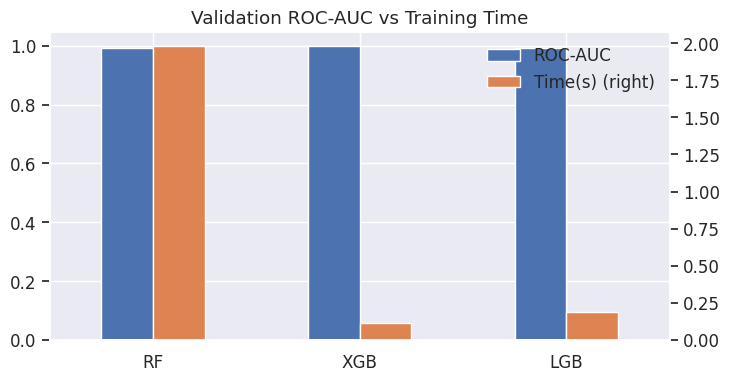

In [12]:
rf = RandomForestClassifier(**rf_best, random_state=42)
xgb_model = xgb.XGBClassifier(**xgb_best, use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(**lgb_best)

models = {"RF": rf, "XGB": xgb_model, "LGB": lgb_model}
val_results = {}

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, preds)
    val_results[name] = (auc, time.time() - start)
    print(f"{name} ROC-AUC: {auc:.4f} | Time: {val_results[name][1]:.2f}s")

df_perf = pd.DataFrame(val_results, index=["ROC-AUC", "Time(s)"]).T
df_perf.plot(kind="bar", secondary_y="Time(s)", rot=0, figsize=(8,4))
plt.title("Validation ROC-AUC vs Training Time")
plt.show()


### Step 8: Stacking Ensemble (OOF-Safe)

- **Base Learners:** Tuned **Random Forest, XGBoost, and LightGBM** models.  
- **Meta-Learner:** **Logistic Regression**.  
- **OOF Predictions:** Out-of-fold predictions from CV used to train the meta-learner, preventing **overfitting**.  
- **Purpose:** Leverage **complementary strengths** of individual models for improved performance over single models.


In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

base_models = [
    ("rf", rf),
    ("xgb", xgb_model),
    ("lgb", lgb_model)
]
meta = LogisticRegression()
stack = StackingClassifier(estimators=base_models, final_estimator=meta, cv=5)
cal_stack = CalibratedClassifierCV(stack, method="sigmoid", cv=5)
cal_stack.fit(X_train, y_train)


CalibratedClassifierCV(cv=5,
                       estimator=StackingClassifier(cv=5,
                                                    estimators=[('rf',
                                                                 RandomForestClassifier(max_depth=12,
                                                                                        n_estimators=1028,
                                                                                        random_state=42)),
                                                                ('xgb',
                                                                 XGBClassifier(base_score=None,
                                                                               booster=None,
                                                                               callbacks=None,
                                                                               colsample_bylevel=None,
                                                                               colsample_bynode=None,
                                                                               colsample_bytree=0.9196701880714097,
                                                                               device=None,
                                                                               early_stopping_rounds=None,
                                                                               enable_catego...
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=496,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None, ...)),
                                                                ('lgb',
                                                                 LGBMClassifier(bagging_fraction=0.8983785352135738,
                                                                                feature_fraction=0.9004513704215932,
                                                                                lambda_l1=0.7851095737853662,
                                                                                lambda_l2=0.9225896381778023,
                                                                                learning_rate=0.022517818484511738,
                                                                                n_estimators=996,
                                                                                num_leaves=18))],
                                                    final_estimator=LogisticRegression()))

### Step 9: Final Evaluation on Holdout Test Set

- **Evaluation Set:** Unseen **test set**.  
- **Metrics & Visualizations:**  
  - **Confusion matrices**  
  - **Classification reports** (precision, recall, F1-score)  
  - **ROC curves**  
  - **Predicted probability distributions** for each class  
- **Purpose:** Provide an **unbiased assessment** of the stacking ensemble’s generalization performance and model confidence.


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        32
           1       0.96      0.96      0.96        54

    accuracy                           0.95        86
   macro avg       0.95      0.95      0.95        86
weighted avg       0.95      0.95      0.95        86



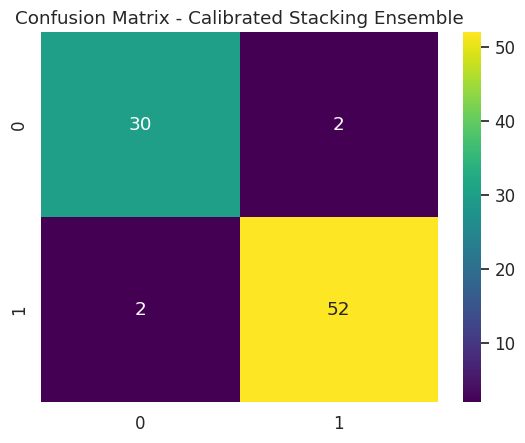

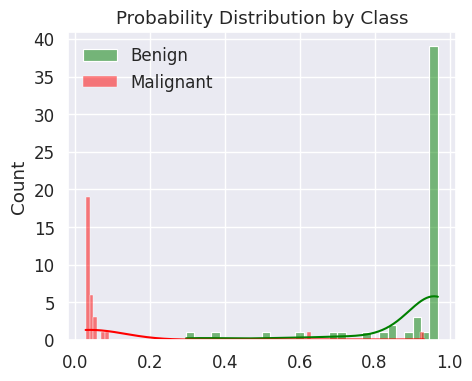

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = cal_stack.predict(X_test)
y_prob = cal_stack.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis')
plt.title("Confusion Matrix - Calibrated Stacking Ensemble")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(y_prob[y_test==1], color="green", label="Benign", kde=True)
sns.histplot(y_prob[y_test==0], color="red", label="Malignant", kde=True)
plt.title("Probability Distribution by Class")
plt.legend()
plt.show()


### Step 10: Permutation Feature Importance & Explainability

- **Purpose:** Measure the impact of each feature on model performance.  
- **Permutation Importance:** Rank features by importance and visualize **top contributors** using bar plots.  
- **SHAP Analysis:**  
  - **Summary plots** for global feature effects  
  - **Dependence plots** to show how individual features influence predictions  
- **Benefit:** Provides **explainability**, crucial for medical datasets.


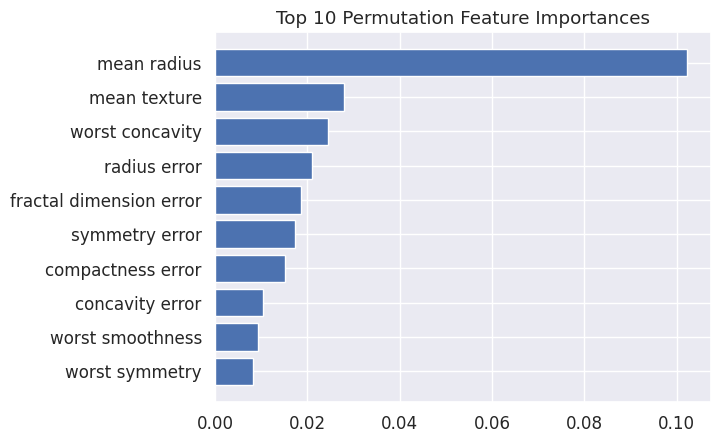

In [15]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(cal_stack, X_val, y_val, n_repeats=10)
sorted_idx = np.argsort(perm.importances_mean)[-10:]

plt.barh(np.array(X_reduced.columns)[sorted_idx], perm.importances_mean[sorted_idx])
plt.title("Top 10 Permutation Feature Importances")
plt.show()


### Step 12: Statistical Tests (t-test & McNemar)

- **Paired t-Test:** Compare **ROC-AUC scores** of different models to assess if differences are **statistically significant**.  
- **McNemar Test:** Evaluate differences in **classification errors** between two models.  
- **Purpose:** Determine whether improvements from **tuning or ensembling** are likely genuine or due to chance.


In [16]:
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

rf_pred = rf.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# ROC-AUC difference significance
rf_probs = rf.predict_proba(X_test)[:,1]
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
t_stat, p_val = ttest_rel(rf_probs, xgb_probs)
print(f"Paired T-Test (RF vs XGB): p={p_val:.5f}")

# McNemar for categorical difference
table = confusion_matrix(rf_pred, xgb_pred)
res = mcnemar(table)
print(f"McNemar test p-value: {res.pvalue:.5f}")


Paired T-Test (RF vs XGB): p=0.43981
McNemar test p-value: 1.00000


### Step 13: Time vs Performance Logging

- **Purpose:** Record **training time** and **performance metrics** for each model.  
- **Visualization:** Scatter plots show the **trade-off between model complexity (time) and performance (ROC-AUC)**.  
- **Benefit:** Helps select models that balance **speed and accuracy** for deployment.


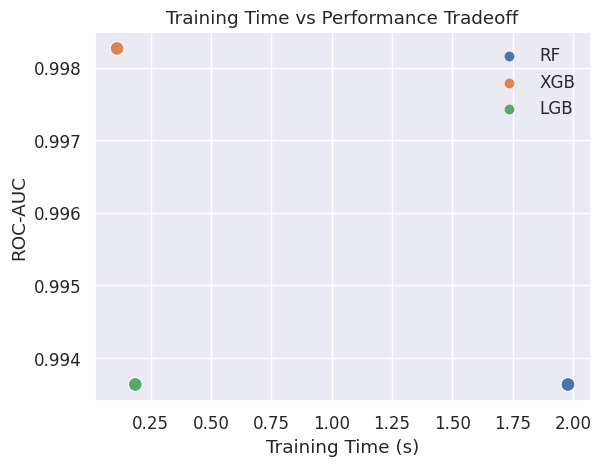

In [17]:
sns.scatterplot(x=df_perf["Time(s)"], y=df_perf["ROC-AUC"], hue=df_perf.index, s=100)
plt.title("Training Time vs Performance Tradeoff")
plt.xlabel("Training Time (s)")
plt.ylabel("ROC-AUC")
plt.show()
